<a href="https://colab.research.google.com/github/nayem9b/Bash-scripting/blob/my_cool_branch/DenseNet_BiLSTM_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization

#from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D,BatchNormalization
from keras.utils import array_to_img, img_to_array, load_img
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3

from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
normal_dir = '/content/drive/MyDrive/all_denoised_document/Speckle Noise/Noised/CNV'
dme_dir = '/content/drive/MyDrive/all_denoised_document/Speckle Noise/Noised/DME'
drusen_dir = '/content/drive/MyDrive/all_denoised_document/Speckle Noise/Noised/DRUSEN'
cnv_dir = '/content/drive/MyDrive/all_denoised_document/Speckle Noise/Noised/NORMAL'
# Image dimensions
image_size = (256, 256)
num_classes = 4  # NORMAL and DME

In [4]:
def load_and_preprocess_images(image_dir, label):
    images = []
    labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            img = load_img(os.path.join(image_dir, filename), target_size=image_size)
            img_array = img_to_array(img)
            img_array /= 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(label)
    return images, labels

In [5]:
normal_images, normal_labels = load_and_preprocess_images(normal_dir, label='NORMAL')
dme_images, dme_labels = load_and_preprocess_images(dme_dir, label='DME')
cnv_images, cnv_labels = load_and_preprocess_images(cnv_dir, label='CNV')
drusen_images, drusen_labels = load_and_preprocess_images(drusen_dir, label='DRUSEN')

In [6]:
print("Normal_images: ", len(normal_images))
print("DME_images: ", len(dme_images))
print("CNV_images: ", len(cnv_images))
print("Drusen_images: ", len(drusen_images))

Normal_images:  1000
DME_images:  1000
CNV_images:  1000
Drusen_images:  1000


In [7]:
all_images = np.array(normal_images + dme_images + drusen_images + cnv_images)
all_labels = np.array(normal_labels + dme_labels + drusen_labels + cnv_labels)


In [8]:
normal_images = 0,
dme_images = 0 ,
drusen_images = 0 ,
cnv_images = 0
normal_labels =0
dme_labels =0
drusen_labels = 0
cnv_labels = 0
all_labels

array(['NORMAL', 'NORMAL', 'NORMAL', ..., 'CNV', 'CNV', 'CNV'],
      dtype='<U6')

In [9]:
# Convert labels to one-hot encoding
label_encoder = LabelEncoder()
all_labels_encoded = label_encoder.fit_transform(all_labels)
all_labels_onehot = tf.keras.utils.to_categorical(all_labels_encoded, num_classes=num_classes)


In [ ]:
all_labels_onehot

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [10]:
train_images, test_val_images, train_labels, test_val_labels = train_test_split(
    all_images, all_labels_onehot, test_size=0.3, random_state=42
)

In [11]:
all_images = 0
all_labels = 0

In [12]:
print("train_images: ", len(train_images))
print("test_val_images: ", len(test_val_images))

train_images:  2800
test_val_images:  1200


In [13]:
test_images, val_images, test_labels, val_labels = train_test_split(
    test_val_images, test_val_labels, test_size=0.5, random_state=42
)

In [14]:
print("train_images: ", len(test_images))
print("test_val_images: ", len(val_images))

train_images:  600
test_val_images:  600


**Main Model Architecture**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_densenet():
    densenet = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
    for layer in densenet.layers:
        layer.trainable = False
    return densenet

def build_model(input_shape):
    model = models.Sequential()
    model.add(build_densenet())
    model.add(layers.Flatten())
    # Calculate the output shape of the Flatten layer
    # and use it in the Reshape layer.
    model.add(layers.Reshape((1, 19200)))
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Bidirectional(layers.LSTM(64)))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

# Example usage
num_classes = 4  # Example: if you have 10 classes
input_shape = (256, 256, 3)  # Example: input image shape

model = build_model(input_shape)
#model.summary()

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [ ]:
#model.summary()


ValueError: Undefined shapes are not supported.

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def __init__(self, threshold=0.97, consecutive=3):
        super(CustomEarlyStopping, self).__init__()
        self.threshold = threshold
        self.consecutive = consecutive
        self.counter = 0
        self.stopped_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')

        if val_acc is not None and val_acc > self.threshold:
            self.counter += 1
            if self.counter >= self.consecutive:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print(f"\nEarly stopping: Training stopped at epoch {epoch + 1} (val_acc={val_acc:.4f}).")

        else:
            self.counter = 0

# Define the custom early stopping callback
custom_early_stopping = CustomEarlyStopping(threshold=0.97, consecutive=3)

In [ ]:
# Compile the model
model.compile(optimizer='adam',  # Choose an optimizer
              loss='categorical_crossentropy',  # Choose a loss function
              metrics=['accuracy'])  # Choose evaluation metrics


In [ ]:
epochs=20
history = model.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=16,
    shuffle=True,
    callbacks=[custom_early_stopping],
    validation_data=(val_images, val_labels)
)


Epoch 1/20


ValueError: The total size of the tensor must be unchanged. Received: input_shape=(65536,), target_shape=(1, 19200)

In [ ]:
model.save('densenet_model.h5')

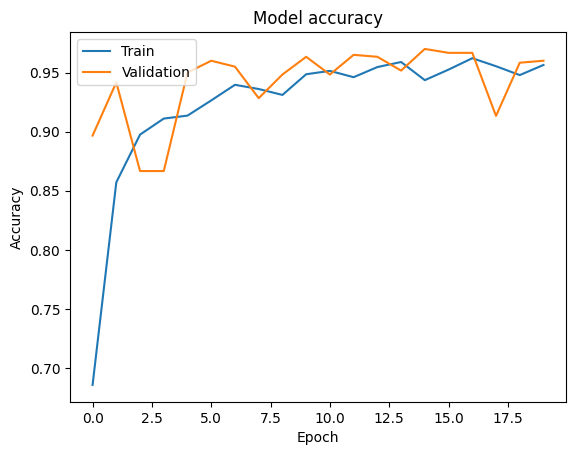

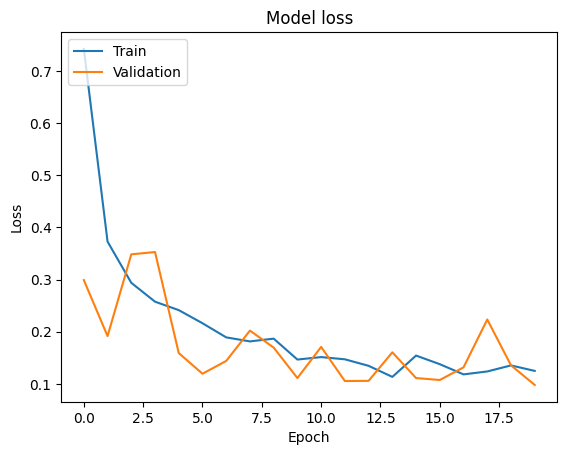

In [ ]:


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score

# Get predictions for the test set
test_predictions = model.predict(test_images)

# Convert predicted probabilities to class labels
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert one-hot encoded true labels to integer labels
test_true_labels = np.argmax(test_labels, axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(test_true_labels, test_predicted_labels)

# Calculate other metrics
test_precision = precision_score(test_true_labels, test_predicted_labels, average='weighted')
test_recall = recall_score(test_true_labels, test_predicted_labels, average='weighted')
test_f1_score = f1_score(test_true_labels, test_predicted_labels, average='weighted')

# Calculate ROC-AUC
test_roc_auc = roc_auc_score(test_labels, test_predictions, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1_score:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")


NameError: name 'model' is not defined

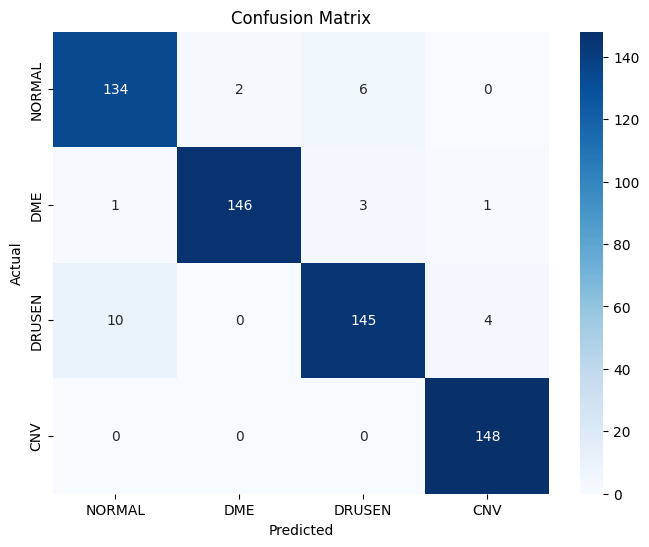

In [ ]:
conf_matrix = confusion_matrix(test_true_labels, test_predicted_labels)
class_names = ["NORMAL", "DME","DRUSEN" , "CNV"]  # Replace with your class names
confusion_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
